In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.model_selection import GridSearchCV
import joblib
# We want our plots to appear inside our notebook
%matplotlib inline


# **Data Loading and Preprocessing:**
Load the data from the URL, preprocess binary features, one-hot encode categorical features, and encode the target variable.

In [2]:
url = "https://raw.githubusercontent.com/hrugved06/Career-Prediction-System/main/data/mldata.csv"
response = requests.get(url)
data = StringIO(response.text)
df = pd.read_csv(data)

In [3]:
# Convert binary features
binary_features = ['self-learning capability?', 'Extra-courses did', 'Taken inputs from seniors or elders', 'worked in teams ever?', 'Introvert']
df[binary_features] = df[binary_features].replace({'yes': 1, 'no': 0})

In [4]:
# One-hot encode categorical features
categorical_features = ['certifications', 'workshops', 'reading and writing skills', 'memory capability score',
                        'Interested subjects', 'interested career area ', 'Type of company want to settle in?',
                        'Interested Type of Books', 'Management or Technical', 'hard/smart worker']

In [5]:
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot", one_hot, categorical_features)], remainder="passthrough")
transformed_X = transformer.fit_transform(df.drop(columns=['Suggested Job Role']))

# Encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Suggested Job Role'])

In [6]:
# Define input parameters and target variable
input_params = ['Logical quotient rating', 'hackathons', 'coding skills rating', 'public speaking points',
                'self-learning capability?', 'Extra-courses did', 'certifications', 'workshops',
                'reading and writing skills', 'memory capability score', 'Interested subjects',
                'interested career area ', 'Type of company want to settle in?',
                'Taken inputs from seniors or elders', 'Interested Type of Books', 'Management or Technical',
                'hard/smart worker', 'worked in teams ever?', 'Introvert']

target_var = 'Suggested Job Role'

# **Correlation heatmap**

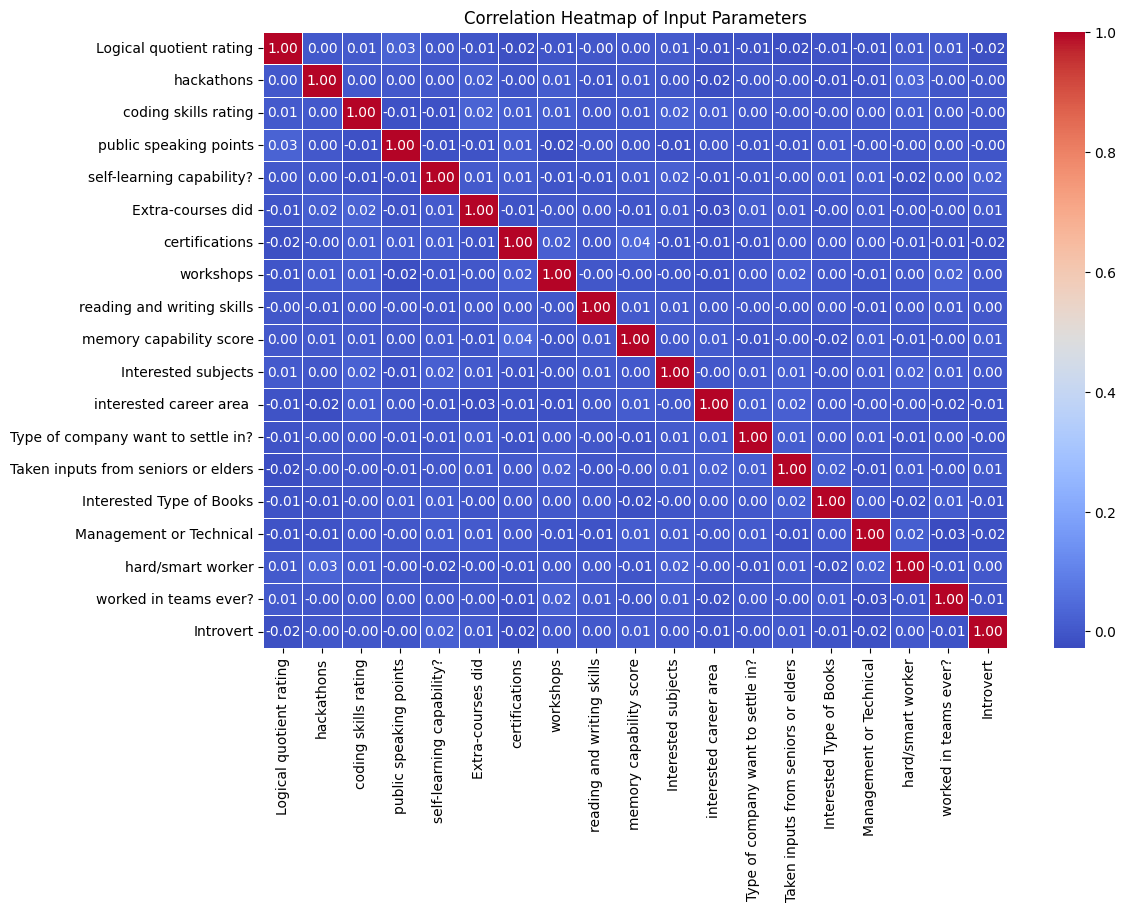

In [7]:
# Convert categorical variables to numerical representations
df_numeric = df.copy()
for column in df_numeric.columns:
    if df_numeric[column].dtype == 'object':
        df_numeric[column] = pd.factorize(df_numeric[column])[0]

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric[input_params].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Input Parameters')
plt.show()

# **Boxplot for target variable**

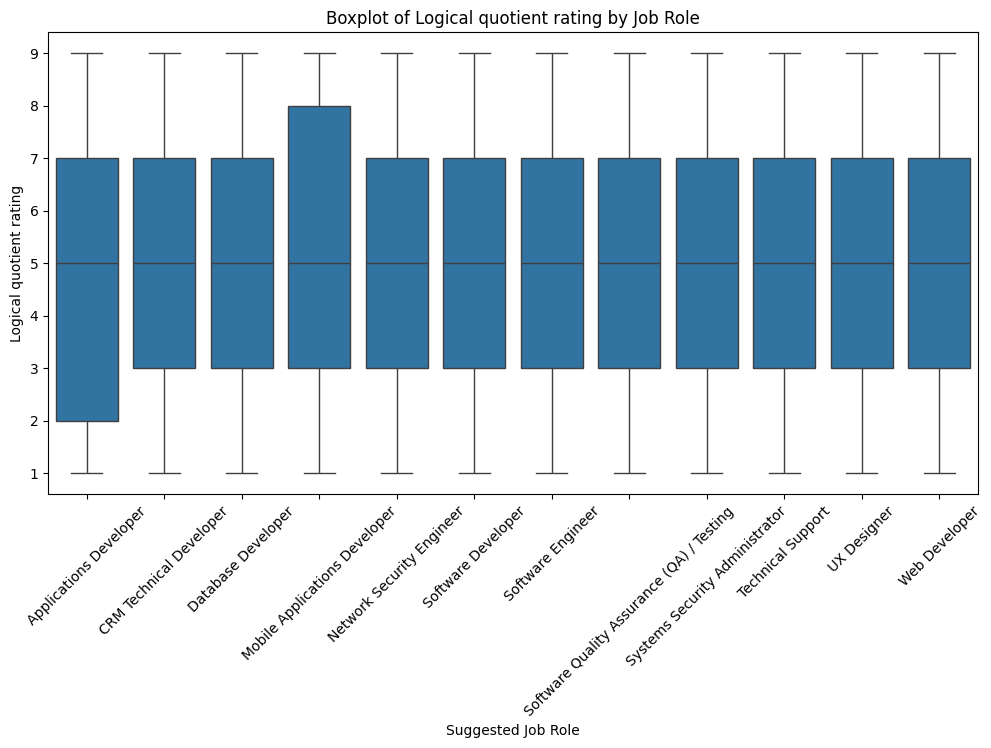

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=target_var, y='Logical quotient rating', data=df)
plt.xticks(rotation=45)
plt.title('Boxplot of Logical quotient rating by Job Role')
plt.show()

# **Data Splitting:**
Split the data into training and testing sets.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.2, random_state=42)


# **Data Transformation:**
Convert sparse matrices to dense arrays and reshape data for CNN input.

In [10]:
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

X_train_reshaped = X_train_dense.reshape(X_train_dense.shape[0], -1, 1)
X_test_reshaped = X_test_dense.reshape(X_test_dense.shape[0], -1, 1)


# **Bar plot for categorical variables**

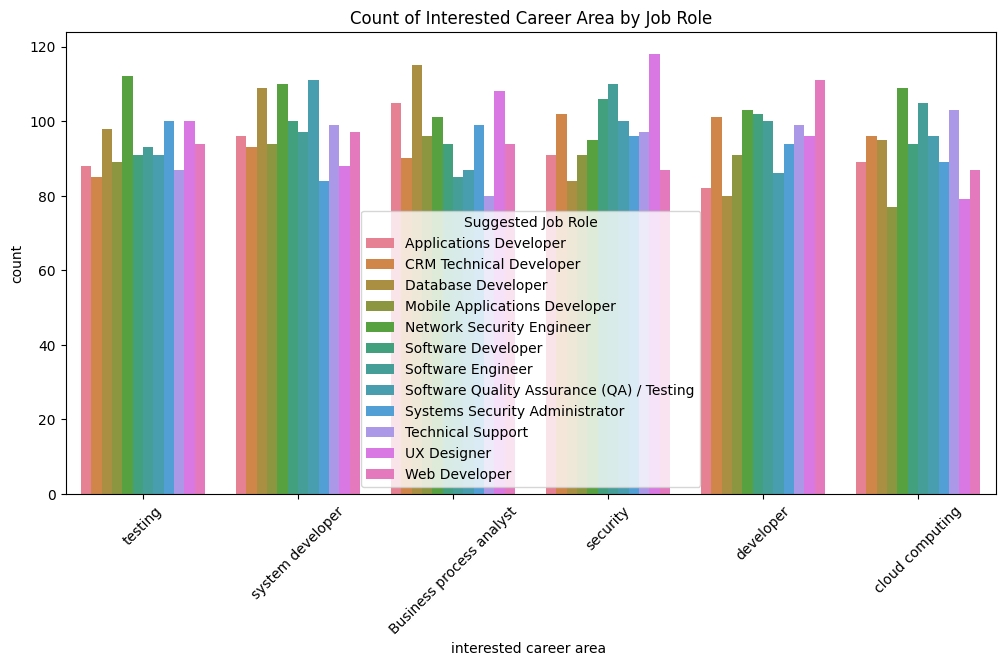

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(x='interested career area ', data=df, hue=target_var)
plt.xticks(rotation=45)
plt.title('Count of Interested Career Area by Job Role')
plt.show()

# **CNN Model Definition and Training:**

In [24]:
# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# CNN-LSTM Model Definition and Training
model = models.Sequential([
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.LSTM(64),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(12, activation='softmax')  # Assuming 12 job roles
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model with hyperparameter tuning
history = model.fit(X_train_reshaped, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.1,
                    verbose=0,
                    callbacks=[LearningRateScheduler(lr_scheduler), early_stopping])

In [27]:
# Evaluate model on test data
np.random.seed(42)
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=0)
print('\nTest accuracy:', test_acc)


Test accuracy: 0.9051412343978882


# **Feature Extraction from CNN:**

In [28]:
cnn_feature_extractor = models.Model(inputs=model.inputs, outputs=model.layers[-3].output)
X_train_features = cnn_feature_extractor.predict(X_train_reshaped)
X_test_features = cnn_feature_extractor.predict(X_test_reshaped)

44/44 [==============================] - 0s 7ms/step


# **SVM Model Training with Hyperparameter Tuning:**

In [35]:
np.random.seed(42)
# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': ['scale', 'auto'],
              'kernel': ['linear', 'rbf']}

# Perform grid search with cross-validation
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_features, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [38]:
# Get the results of the grid search
# results = grid_search.cv_results_
# mean_test_scores = results['mean_test_score'].reshape(len(param_grid['C']), len(param_grid['gamma']))

results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']
print("Shape of mean_test_scores:", mean_test_scores.shape)
print("mean_test_scores:", mean_test_scores)

Shape of mean_test_scores: (24,)
mean_test_scores: [0.92210145 0.92210145 0.92210145 0.92210145 0.92210145 0.92210145
 0.92210145 0.92210145 0.92210145 0.92210145 0.92210145 0.92210145
 0.92210145 0.92028986 0.92210145 0.92210145 0.89311594 0.84601449
 0.89311594 0.92210145 0.85507246 0.84057971 0.85507246 0.92210145]


# **Plotting**

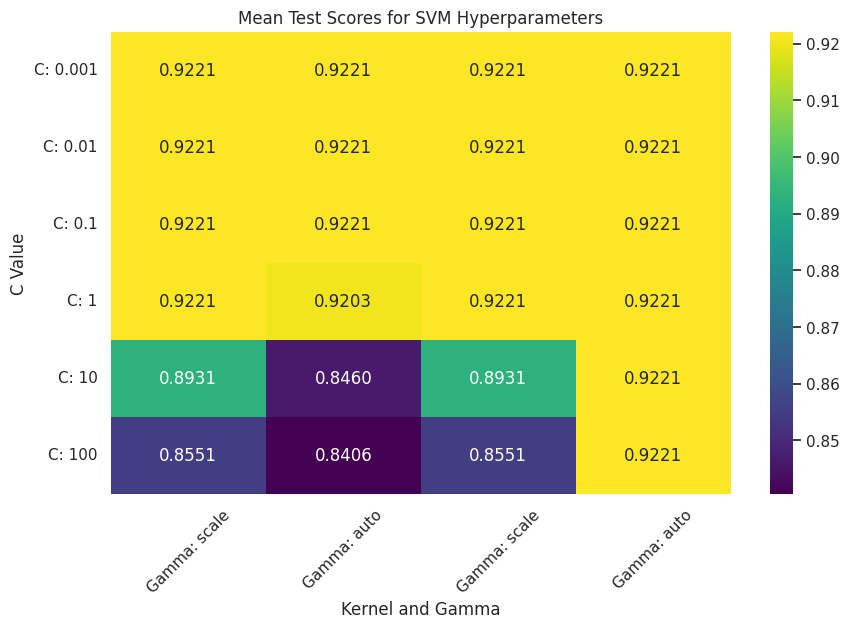

In [41]:
# Define the hyperparameters and their values
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
gamma_values = ['scale', 'auto']
kernel_values = ['linear', 'rbf']

# Extract the mean test scores from your grid search results
mean_test_scores = np.array([0.92210145, 0.92210145, 0.92210145, 0.92210145, 0.92210145, 0.92210145,
                             0.92210145, 0.92210145, 0.92210145, 0.92210145, 0.92210145, 0.92210145,
                             0.92210145, 0.92028986, 0.92210145, 0.92210145, 0.89311594, 0.84601449,
                             0.89311594, 0.92210145, 0.85507246, 0.84057971, 0.85507246, 0.92210145])

# Reshape the scores into a grid for plotting
scores_grid = mean_test_scores.reshape(len(C_values), len(gamma_values) * len(kernel_values))

# Create a heatmap using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.heatmap(scores_grid, annot=True, fmt='.4f', cmap='viridis',
            xticklabels=[f"Gamma: {gamma}" for gamma in gamma_values * len(kernel_values)],
            yticklabels=[f"C: {C}" for C in C_values])
plt.title('Mean Test Scores for SVM Hyperparameters')
plt.xlabel('Kernel and Gamma')
plt.ylabel('C Value')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


# **Print best parameters and best accuracy**

In [45]:
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Cross-Validated Accuracy:", best_accuracy)

Best Parameters: {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validated Accuracy: 0.9221014492753623


# **Evaluate the model with the best parameters on test data**


In [47]:
best_svm_classifier = grid_search.best_estimator_
svm_pred = best_svm_classifier.predict(X_test_features)
test_accuracy = accuracy_score(y_test, svm_pred)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8761766835626359


# **Exporting the model**

In [49]:
import joblib

# Define the filename for saving the model
filename = 'CNN-SVM_model.pkl'

# Save the model to a file
joblib.dump(best_svm_classifier, filename)

print("Model saved to", filename)

Model saved to CNN-SVM_model.pkl
